<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#데이터-Tokenize-Process" data-toc-modified-id="데이터-Tokenize-Process-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>데이터 Tokenize Process</a></span><ul class="toc-item"><li><span><a href="#검색어-입력" data-toc-modified-id="검색어-입력-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>검색어 입력</a></span></li><li><span><a href="#데이터-불러오기(raw-data)" data-toc-modified-id="데이터-불러오기(raw-data)-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>데이터 불러오기(raw data)</a></span></li><li><span><a href="#전처리-(기사-분문)" data-toc-modified-id="전처리-(기사-분문)-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>전처리 (기사 분문)</a></span></li><li><span><a href="#전처리-(기사-제목)" data-toc-modified-id="전처리-(기사-제목)-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>전처리 (기사 제목)</a></span></li><li><span><a href="#전처리된-데이터-저장" data-toc-modified-id="전처리된-데이터-저장-1.5"><span class="toc-item-num">1.5&nbsp;&nbsp;</span>전처리된 데이터 저장</a></span></li></ul></li><li><span><a href="#Category-및-Topic-할당" data-toc-modified-id="Category-및-Topic-할당-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Category 및 Topic 할당</a></span><ul class="toc-item"><li><span><a href="#유효문서-추출" data-toc-modified-id="유효문서-추출-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>유효문서 추출</a></span><ul class="toc-item"><li><span><a href="#유효문서-추출-A" data-toc-modified-id="유효문서-추출-A-2.1.1"><span class="toc-item-num">2.1.1&nbsp;&nbsp;</span>유효문서 추출 A</a></span></li><li><span><a href="#유효문서-추출-B" data-toc-modified-id="유효문서-추출-B-2.1.2"><span class="toc-item-num">2.1.2&nbsp;&nbsp;</span>유효문서 추출 B</a></span></li></ul></li><li><span><a href="#문서별-카테고리-할당" data-toc-modified-id="문서별-카테고리-할당-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>문서별 카테고리 할당</a></span></li><li><span><a href="#카테고리-별-토픽-할당" data-toc-modified-id="카테고리-별-토픽-할당-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>카테고리 별 토픽 할당</a></span></li><li><span><a href="#토픽-별-대표기사-추출" data-toc-modified-id="토픽-별-대표기사-추출-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>토픽 별 대표기사 추출</a></span></li></ul></li><li><span><a href="#sqlite에-저장" data-toc-modified-id="sqlite에-저장-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>sqlite에 저장</a></span></li><li><span><a href="#그외-필요한-코드" data-toc-modified-id="그외-필요한-코드-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>그외 필요한 코드</a></span></li></ul></div>

In [4]:
import modules.newsight as ns 

# file I/O
import pickle
import pandas as pd

import time # check excution time

# 경고 메시지 숨기기
import warnings
warnings.filterwarnings("ignore")

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#처리-단계-명세" data-toc-modified-id="처리-단계-명세-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>처리 단계 명세</a></span></li></ul></div>

처리 단계 명세

**DB** <font color='red'>전처리(토큰화)</font>  

1. **검색어 입력**
2. **데이터 불러오기**(raw data)   
1. **전처리**  
    1.1. 특수문자, 일반적 불용어 제거  
    1.2. 유효 명사 추가     
    1.4. 검색어에 대한 불용어 제거  
    1.3. 명사 추출  

**Backend** workflow v3 유효기사추출 - 대표기사추출.ipynb 

1. **검색어 입력**
2. **데이터 불러오기**(tokenized data)
3. **유효문서 추출**  
    3.2. 유효 문서 추출 A (제목에 검색어를 포함하는 문서만 추출, 제목에 [ ]가 들어간 문서 제외)  
    3.3. 유효 문서 추출 B (본문에 검색어가 3번 이상 들어가는 문서만 추출) 
4. **문서별 카테고리 할당**
5. **카테고리 별 토픽 할당**  
    5.1. 벡터화 (TFIDF)  
    5.2. 군집화 (DBSCAN)
6. **토픽 별 대표기사 추출**
    6.1. 토픽별 문서 벡터화 (TFIDF)  
    6.2. 토픽별 대표 키워드 추출 (SVD)  
    6.3. 토픽별 대표 문서 추출 (BM25)  
    
**Frontend**  workflow v3 시각화.ipynb 

    
**References**  
[1] 현호\_mulcam_mirae_workflow.ipynb

**기타**  
각 블록 마다 running time 측정

## 데이터 Tokenize Process
### 검색어 입력
### 데이터 불러오기(raw data)

In [5]:
query = '이니스프리'
loader = ns.Pickle2DF()
# df_raw = loader.get_dataframe(f'data/{query}/rawdata_{query}.pickle')
df_raw = pd.read_csv(f'data/{query}/{query}.csv')
df_raw = df_raw.drop([int(f'{len(df_raw)-1}')],axis=0) #마지막핼 크롤링 실패해서 마지막줄 잘라줘야함
df_raw =loader.get_dataframe_from_csv(df_raw) # 2nd 크롤링 csv파일 처리함수 추가

### 전처리 (기사 분문)
- 특수문자, 일반적 불용어 제거
- 유효 명사 추가
- 검색어에 대한 불용어 제거
- 명사 추출

In [6]:
tic = time.time()

# 전처리 
pp = ns.PreprocessingText()
content_no_stopwords = pp.make_content_re(df_raw['content']) # 일반적인 불용어, 특수문자 제거

# 유효 명사 추가
noun_dict_route = 'data/미래에셋_단어사전.txt'
with open(noun_dict_route,encoding = 'utf-8-sig') as f: noun_proper = f.read() # 최초 1회만 하고 이후 주석처리
noun_list = noun_proper.split('\n')
pp.add_noun_dict(noun_list) 

# 검색어에 대한 불용어 추가
stopword_dict_route = 'data/미래에셋_불용어사전.txt'
with open(stopword_dict_route,encoding = 'utf-8-sig') as f2: stopword = f2.read() # 최초 1회만 하고 이후 주석처리
stopword_list = stopword.split('\n')
pp.add_stopwords(stopword_list) 

# 명사 추출
content_tk = pp.tokenize(content_no_stopwords)

toc = time.time()
print(f'excution time : {toc-tic}')

추가한 명사
['정보통신', '환헤지', '조웅기', '핀테크', '큐레이션', '투명성', '최경주', '상장', '임직원', '아시아그로쓰', '라이징스타', '파이낸셜', '캡스', '리파이낸싱', '싱가포르투자청', '도이체방크', '도이치뱅크', '카우룽', '그린마크', '광주은행', '대신증권', '삼성생명', '신한은행', '우리은행', '유안타증권', '펀드슈퍼마켓', '한국투자증권', '기업은행', '하나은행', '제일은행', '퀀트모델', '포트폴리오', '헤지펀드', '트레이딩', '영업점', '셀렉션', '구인', '사업화', '협약식', '미래에셋센터원', '최연소', '이테크', '미래에셋', '미래에셋대우', '에트리홀딩스', '펀드설정액', '분기', '벤처', '사회적기업', '성장지원', '헬스케어', '해결책', '메리츠', '신고가', '지주', '증권주', '벨류에이션', '이베스트', '수익성', '실사구시', '페어트레이딩', '쓸어', '상장사', '한투', '한국투자증권', '순매수', '거래량', '상장주식수', '분기', '미상환', '업무지구', '장기적', '한온시스템', '보여', '주간사', '젠바디', '예탁결제원', '크라우드펀딩', '영업이익률', '이익률', '파워리퍼블릭', '운용사', '아모텍', '지분', '박스권', '저평가', '시총', '긍정적', '납세자', '셀리드', '에스퓨얼셀', '게임사', '할인율', '재도전', '인공지능', '당기순익', '비대면', '사업가치', '재평가', '순매도', '순매수', '수혜주', '마중물', '혼조세', '신고가', '합리적', '재취업', '다각화', '자문형랩', '순익', '설정액', '원소재', '메디톡스', '인허가', '성장통', '호실적', '주간사', '주관사', '예상치', '호실적', '압도', '신성장', '기술료', '조기상환', '비임원', '기대감', '순매도', '저평가', '거래량', '내수', '건설사', 

### 전처리 (기사 제목)
- 특수문자, 일반적 불용어 제거
- 유효 명사 추가
- 검색어에 대한 불용어 제거
- 명사 추출

In [7]:
tic = time.time()
# 제목

# 전처리 
pp = ns.PreprocessingText()
content_no_stopwords_title = pp.make_content_re(df_raw['title']) # 일반적인 불용어, 특수문자 제거

# # 유효 명사 추가
# noun_dict_route = 'data/미래에셋_단어사전.txt'
# with open(noun_dict_route,encoding = 'utf-8-sig') as f: noun_proper = f.read()
# noun_list = noun_proper.split('\n')
# pp.add_noun_dict(noun_list) 

# # 검색어에 대한 불용어 추가
# stopword_dict_route = 'data/미래에셋_불용어사전.txt'
# with open(stopword_dict_route,encoding = 'utf-8-sig') as f2: stopword = f2.read()
# stopword_list = stopword.split('\n')
# pp.add_stopwords(stopword_list) 

# 명사 추출
content_tk_title = pp.tokenize(content_no_stopwords_title)

toc = time.time()
print(f'excution time : {toc-tic}')

추가한 명사: []
불용어:  []
excution time : 2.3283848762512207


### 전처리된 데이터 저장

In [8]:
df_raw['tokenized_doc'] = content_tk
df_raw['tokenized_title'] = content_tk_title
# with open('tokenized data/tkdata_미래에셋대우.pickle','wb') as handle:
#     pickle.dump(df_raw,handle,protocol=pickle.HIGHEST_PROTOCOL)

## Category 및 Topic 할당
1. **유효문서 추출**  
    1.2. 유효 문서 추출 A (제목에 검색어를 포함하는 문서만 추출, 제목에 [ ]가 들어간 문서 제외)  
    1.3. 유효 문서 추출 B (본문에 검색어가 3번 이상 들어가는 문서만 추출) 
2. **문서별 카테고리 할당**
3. **카테고리 별 토픽 할당**  
    3.1. 벡터화 (TFIDF)  
    3.2. 군집화 (DBSCAN)
4. **토픽 별 대표기사 추출**
    4.1. 토픽별 문서 벡터화 (TFIDF)  
    4.2. 토픽별 대표 키워드 추출 (SVD)  
    4.3. 토픽별 대표 문서 추출 (BM25)  

In [9]:
# 시각화
import matplotlib.pyplot as plt
import seaborn as sb

import re # 정규표현식
import numpy as np # 연산
process = ['load_data' ,' preprocess - get proper docs A','preprocess - get proper doc B', 'get category', 'get topic - vectorize',
'get topic-DBSCAN','get main doc']

In [10]:
selector = ns.GetDocsFromQuery() # 유효문서 추출 A
pp = ns.PreprocessingText() # 전처리
cleaner = ns.CleaningNoise() # 유효문서 추출 B

selector.help()
pp.help()
cleaner.help()

c:\users\smnoh\appdata\local\programs\python\python36\lib\site-packages\konlpy\tag\_okt.py:16: UserWarning: "Twitter" has changed to "Okt" since KoNLPy v0.4.5.
  warn('"Twitter" has changed to "Okt" since KoNLPy v0.4.5.')


******GetDocsFromQuery******
1)set_query(검색어(str)) : 검색어 설정 
2)select_news(데이터프레임(DataFrame),title) : 검색어를 포함한 문서를 시리즈로 반환, title = True 면 제목에 쿼리를 포함한 문서 인덱스 반환
*****************************
******PreprocessingText******
1) make_content_re(df['컬럼이름'](Series)) : 입력받은 열을 전처리 후 시리즈로 반환
2) add_noun_dict('list') : 명사 사전에 단어 추가
3) add_stopwords('list') : 불용어 사전에 단어 추가
4) tokenize(df['컬럼이름'](Series)) : 입력받은 열을 토큰화한 후 시리즈로 반환
5) change_similar_words(토큰화된 문서(Series), 유의어 사전(dictionary)) : 유의어 사전을 기반으로 문서 내 유의어를 대표어로 변환하고, 변환된 문서를 시리즈로 반환한다.
*****************************
******CleaningNoise******
1)count_topic(토큰화된문서(Series),단어(str)) : 각 문서당 특정 단어가 몇번 포함됐는지를 리스트로 출력
2)plot_hist(count_topic 에서 반환된 카운트리스트(list)) : 1 에서 반환된 리스트로 히스토그램을 그린다
3)get_proper_news(토큰화된문서(Series), count_topic 에서 반환된 카운트리스트(list), 기준치(int): 문서 내 특정 단어가 기준치 이상 나온 문서만 반환한다.
*****************************


### 유효문서 추출
#### 유효문서 추출 A  
제목에 검색어를 포함하는 문서만 추출  
제목에 '[\w+]'를 포함하는 문서 제외

In [11]:
# 제목에 검색어를 포함하는 문서 인덱스 추출
selector.set_query(query)
idx_proper_title = selector.select_news(df_raw, title = True) 
df_proper_title = df_raw.loc[idx_proper_title]

# [ET투자뉴스],[마켓인사이트] 등의 기사 제거
# [단독], [속보], [2보] 등은 남겨야함
idx_special_title = []
regex = "\[\w{4,20}\]"
for i in df_proper_title.index:
    if re.search(regex,df_proper_title.loc[i]['title']) is not None: idx_special_title.append(i)

df_proper_title.drop(idx_special_title,inplace = True)
print(f'length of proper title : {df_proper_title.shape[0]}')

length of selected news: 383
length of original data: 2456
length of proper title : 365


#### 유효문서 추출 B  
본문에 검색어를 3번이상 포함하는 문서만 추출

In [12]:
query_counter = cleaner.count_topic(df_proper_title['tokenized_doc'],query)
proper_idx = cleaner.get_proper_news(df_proper_title['tokenized_doc'],query_counter, 2).index.tolist()
df_proper = df_proper_title.loc[proper_idx].copy()

number of total data: 365
number of proper data: 317


### 문서별 카테고리 할당

In [13]:
keyword_extractor = ns.GetKeyword() # 카테고리 할당 모듈
keyword_extractor.help()

******GetKeyword******
1)top_df(토큰화된 문서(Series)) : 문서에 포함된 단어의 DF를 계산하고, 단어에 따른 DF를 데이터프레임으로 반환한다.
2)top_tfidf(tfidf 벡터(np.ndarray), tfidf 벡터의 features(np.array), top_n(int)) : 각 문서별 tfidf가 가장 큰 단어 3개를 뽑고, 그 단어들의 빈도를 시리즈로 반환한다.
3)lda(tfidf 벡터(np.ndarray),tfidf 벡터의 features(np.array), 토픽수(int), 토픽당 출력할 단어 수(int)) : 토픽에 따라 선정된 키워드를 출력한다. 각 문서의 토픽 번호를 리스트로 반환한다.
4)get_issues_based_dataframe(self, 데이터프레임(dataframe), 주제별 키워드 리스트(list), 주제당 뽑고 싶은 기사 수(int) , 컬럼이름(str)
주제별 키워드 형식 : [[k11,k12,k12...],[k21,k22,...],...,[kn1,kn2]]
주제당 가장 bm25 score가 높은 기사를 뽑아서 데이터 프레임으로 반환한다
5)remove_na_category(데이터프레임(DataFrame)) : 카테고리가 있는 문서만 반환한다. 카테고리가 없는 문서를 제거 전/후 문서의 수를 출력한다.
6)select_category(카테고리(Series)) :카테고리 리스트 내에서 원소 한개를 선택해 반환한다.

            카테고리 원소 형식 : [cat_1>cat_2, cat_1>cat_2, cat_1>cat_2],[...],[...],...
            6-1) cat_1>cat2 에서 cat2 를 제거하고, 중복된 cat_1을 제거한다.
            6-2) cat_1의 빈도 분포를 출력한다.
            6-3) cat_1에서 가장 빈도가 높은 카테고리를 major_cat, 나머지를 빈도 순서대로 minor_cat에 저장한다.
         

In [14]:
def select_category(category):          
    # cat_2 제거, 중복된 cat_1 제거
    cat_1 = []
    cat_tmp = []
    for cat_list in category :
        tmp = []
        for cat in cat_list :
            tmp.append(re.sub(r'\>\w+','',cat))
        cat_1.extend(list(set(tmp)))
        cat_tmp.append(list(set(tmp)))

    # 카테고리 원소 빈도 출력
    cat_1_table = pd.Series(cat_1).value_counts()
    #print(cat_1_table)
    #print(len(cat_tmp))

    tmp = cat_1_table.index.tolist()
    major_cat = tmp[0]
    minor_cat_list = tmp[1:]
    minor_cat_list.reverse()

    print(f'major category : {major_cat}')
    print(f'minor categories : {minor_cat_list}')

    # 카테고리 원소 선택 
    selected_cat = []
    for cat in cat_tmp : 
        if(len(cat)==1) : selected_cat.append(cat[0])
        else :
            for minor_cat in minor_cat_list:
                if minor_cat in cat : 
                    selected_cat.append(minor_cat)
                    break
                else : 
                    selected_cat.append(major_cat)
                    break
    selected_cat = pd.Series(selected_cat)
    display(selected_cat.value_counts())
    return selected_cat

In [15]:
#인덱스 초기화 해야함
df_cat_proper = keyword_extractor.remove_na_category(df_proper).reset_index(drop=True)

n_docs : 317
n_docs after remove na categories : 317


In [16]:
cat_selected = keyword_extractor.select_category(df_cat_proper['category'])
df_cat_proper['cat_selected'] = cat_selected

경제       232
지역        54
문화        49
IT_과학     42
국제        12
미분류       10
사회         3
정치         1
dtype: int64
317
major category : 경제
minor categories : ['지역', '문화', 'IT_과학', '국제', '미분류', '사회', '정치']


In [17]:
# 클러스터의 개수가 1이하인 문서는 버린다.
threshold = 1
rm_cat_list = df_cat_proper['cat_selected'].value_counts()[df_cat_proper['cat_selected'].value_counts()<5].index.tolist()
for rm_cat in rm_cat_list:
    idx = df_cat_proper[df_cat_proper['cat_selected']==rm_cat].index.tolist()
    df_cat_proper.drop(idx,inplace = True)

### 카테고리 별 토픽 할당
- 벡터화

In [18]:
vectorizer = ns.Vectorizer()
cluster = ns.Get2DPlot()

In [19]:
x_cat_dict = {} # 카테고리별 tfidf 벡터
word_cat_dict = {} # 카테고리별 단어
cat_list = df_cat_proper['cat_selected'].unique().tolist() # 카테고리 리스트
print(cat_list)

for cat in cat_list:
    vec_obj = ns.Vectorizer()
    cat_docs = df_cat_proper[df_cat_proper['cat_selected'] == cat]['tokenized_doc']
    
    x_cat,word_cat = vec_obj.get_tfidf_vec(cat_docs)
    
    x_cat_dict[cat] = x_cat
    word_cat_dict[cat] = word_cat

['경제', '지역', '문화', 'IT_과학', '미분류', '국제']


****경제****
PCA OPTICS


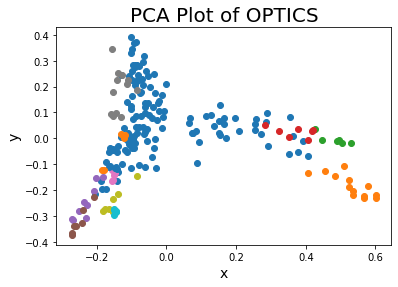

****지역****
PCA OPTICS


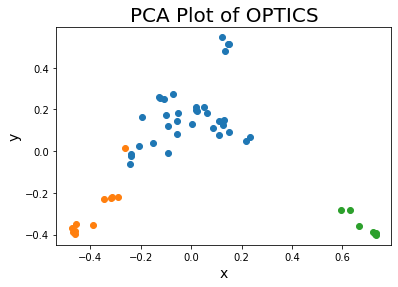

****문화****
PCA OPTICS


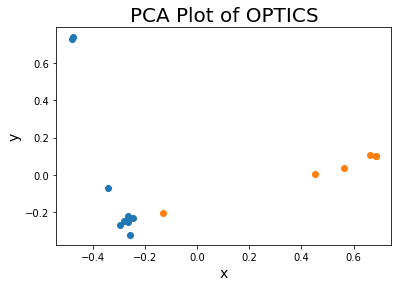

****IT_과학****
PCA OPTICS


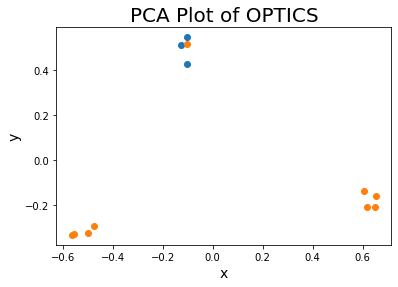

****미분류****
PCA OPTICS


c:\users\smnoh\appdata\local\programs\python\python36\lib\site-packages\sklearn\cluster\optics_.py:491: UserWarning: All reachability values are inf. Set a larger max_eps or all data will be considered outliers.
  UserWarning)


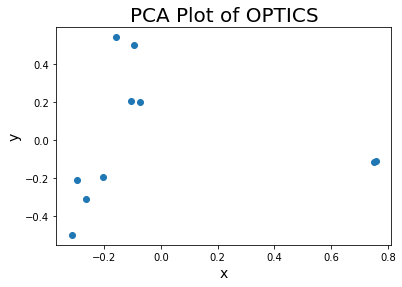

****국제****
PCA OPTICS


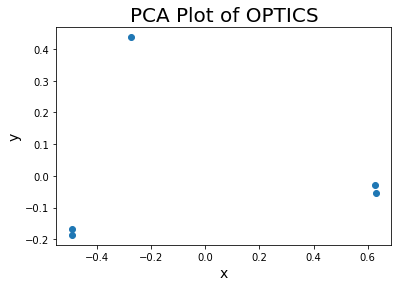

In [20]:
topic_label_dict = {}
for category, tfidf_vec in x_cat_dict.items():
    cluster_obj = ns.Get2DPlot()
    
    print(f'****{category}****')
    
    vec_2d = cluster_obj.get_2D_vec(tfidf_vec,'tfidf','PCA')
    topic_label = cluster_obj.get_cluster_labels(True,cluster_method= 'OPTICS')
    cluster_obj.plot2D()  
    
    topic_label_dict[category] = topic_label

In [21]:
# 카테고리별 토픽할당
df_final = pd.DataFrame()
for cat in cat_list:
    df_tmp = df_cat_proper[df_cat_proper['cat_selected'] == cat].copy()
    df_tmp['topic'] = topic_label_dict[cat]
    df_final = pd.concat([df_final,df_tmp])

### 토픽 별 대표기사 추출

In [22]:
df_main = keyword_extractor.get_news(df_final)

In [23]:
eco_news = df_final[df_final['cat_selected']=='경제'].copy()
topics = eco_news['topic'].unique().tolist()
for topic in topics:
#     print(f'=====topic {topic}=====')
    tmp = eco_news[eco_news['topic']==topic].copy()
#     display(tmp['title'])

In [24]:
# df_final의 represent컬럼 추가
tmp_represent = []
for title in df_final.index :
    if title in df_main.index :
        tmp_represent.append(True)
    else:
        tmp_represent.append(False)

df_final['represent'] = tmp_represent

In [25]:
df_final['category'] = df_final['category'].apply(lambda x: ','.join(x))
df_final['tokenized_doc'] = df_final['tokenized_doc'].apply(lambda x: ','.join(x))
df_final['tokenized_title'] = df_final['tokenized_title'].apply(lambda x: ','.join(x))
df_final['query'] = query
df_final.reset_index(drop=True)

,title,date,category,content,company,date_tmp,tokenized_doc,tokenized_title,cat_selected,topic,represent,query
0,"이니스프리, 에코손수건 10주년 캠페인…한정판 제품도 출시",2019-06-03,"경제>서비스_쇼핑,경제>유통,경제>산업_기업",[아시아경제 차민영 기자] 자연주의 화장품 브랜드 이니스프리가 '2019 에코손수건...,아시아경제,737213,"아시아,경제,자연,주의,화장품,브랜드,이니스프리,에코,손수건,캠페인,론칭,한정판,제...","이니스프리,에코,손수건,주년,캠페인,한정판,제품,출시",경제,-1,False,이니스프리
1,"이니스프리, '포레스트 포맨 올인원 에센스' 모델에 블락비 피오 발탁",2019-05-31,"경제>서비스_쇼핑,경제>유통,경제>산업_기업",[아시아경제 차민영 기자] 자연주의 화장품 브랜드 이니스프리가 그룹 블락비 멤버 피...,아시아경제,737210,"아시아,경제,자연,주의,화장품,브랜드,이니스프리,그룹,블락비,멤버,피오,포레스트,포...","이니스프리,포레스트,포맨,올인원,에센스,모델,블락비,피오,발탁",경제,-1,False,이니스프리
2,"이니스프리, #여름파데 1524 캠페인 실시 ""파운데이션 바꾸면 지원금""",2019-05-20,"경제>유통,경제>서비스_쇼핑,문화>요리_여행",[아시아경제 차민영 기자] 자연주의 화장품 브랜드 이니스프리가 베이스 메이크업이 고...,아시아경제,737199,"아시아,경제,자연,주의,화장품,브랜드,이니스프리,베이스,메이크업,고민,여름철,여름,...","이니스프리,여름,캠페인,실시,파운데이션,지원,금",경제,-1,False,이니스프리
3,이니스프리 신상 화장품 콘셉트는 '고객'…수분·진정 솔루션 메이드바이유,2019-05-16,"경제>서비스_쇼핑,경제>유통,경제>산업_기업",[아시아경제 차민영 기자] 자연주의 화장품 브랜드 이니스프리가 콘셉트 기획부터 제형...,아시아경제,737195,"아시아,경제,자연,주의,화장품,브랜드,이니스프리,콘셉트,기획,개발,고객,힘,탄생,스...","이니스프리,신상,화장품,콘셉트,고객,수분,진정,솔루션,메이드,바이,유",경제,-1,False,이니스프리
4,"'이니스프리' 빅 세일, 최대 65% 혜택받으세요",2019-05-15,"경제>서비스_쇼핑,경제>유통,경제>산업_기업",화장품 브랜드 이니스프리에서 빅 세일을 시작해 많은 관심을 받고 있다.\r\n15일...,광주일보,737194,"화장품,브랜드,이니스프리,빅,시작,관심,이니스프리,날,할인,행사,진행,해당,기간,이...","이니스프리,빅,일,최대,혜택",경제,0,True,이니스프리
5,"이니스프리, 5000원 섀도우를 1700원에? 15일부터 최대 65% '빅세일'",2019-05-15,"경제>산업_기업,경제>서비스_쇼핑,경제>유통",이니스프리가 5월 15일 수요일부터 18일 토요일까지 3일간 최대 65%까지 할인하...,광주일보,737194,"이니스프리,수요일,토요일,인하,빅세일,진행,이니스프리,인기,품목,마이,아이섀도우,마...","이니스프리,원,섀도우,원,부터,최대,빅세일",경제,-1,False,이니스프리
6,이니스프리 ‘빅세일’ 유의사항…‘할인前 판매가 5만원’ 할인혜택 기준!,2019-05-15,"경제>서비스_쇼핑,경제>유통,경제>산업_기업",아모레퍼시픽 계열 화장품 브랜드 이니스프리가 역대급 혜택을 내건 ‘빅세일’을 오는 ...,아주경제,737194,"아모레퍼시픽,계열,화장품,브랜드,이니스프리,역대,급,혜택,건,빅세일,진행,품목,할인...","이니스프리,빅세일,유의사항,할인,판매,만원,할인,혜택,기준",경제,0,False,이니스프리
7,"이니스프리, 최대 65% 할인 이벤트…40% 할인쿠폰도 선착순 지급",2019-05-15,"경제>서비스_쇼핑,경제>유통,경제>산업_기업",15일 이니스프리 PC 홈페이지 내 이벤트 페이지 갈무리.\r\n아모레퍼시픽의 로드...,세계일보,737194,"이니스프리,홈페이지,이벤트,페이지,갈무리,아모레퍼시픽,로드,샵,화장품,브랜드,이니스...","이니스프리,최대,할인,이벤트,할인,쿠폰,선착순,지급",경제,0,False,이니스프리
8,이니스프리 '벡세일'…18일까지 최대 65% 할인,2019-05-15,"경제>서비스_쇼핑,경제>유통,경제>산업_기업",이니스프리 홈페이지 캡처.\r\n\r\n\r\n\r\n화장품 브랜드 이니스프리가 '...,부산일보,737194,"이니스프리,홈페이지,캡처,화장품,브랜드,이니스프리,빅세일,진행,이니스프리,날,할인,...","이니스프리,벡세일,까지,최대,할인",경제,0,False,이니스프리
9,"이니스프리, 40% 할인쿠폰 검색 통해서만 다운로드 가능",2019-05-15,"경제>유통,IT_과학>인터넷_SNS,경제>산업_기업","이니스프리가 5월 빅세일을 시작한다고 밝힌 가운데, 모바일 네이버 검색을 통해서만 ...",경인일보,737194,"이니스프리,빅세일,시작,가운데,모바일,네이버,검색,만,할인,쿠폰,화제,진행,이니스프...","이니스프리,할인,쿠폰,검색,통해,만,다운로드,가능",경제,0,False,이니스프리


In [26]:
# DB에 저장 가능한 상태!!!!!!!!!!!!!!!
df_final

,title,date,category,content,company,date_tmp,tokenized_doc,tokenized_title,cat_selected,topic,represent,query
0,"이니스프리, 에코손수건 10주년 캠페인…한정판 제품도 출시",2019-06-03,"경제>서비스_쇼핑,경제>유통,경제>산업_기업",[아시아경제 차민영 기자] 자연주의 화장품 브랜드 이니스프리가 '2019 에코손수건...,아시아경제,737213,"아시아,경제,자연,주의,화장품,브랜드,이니스프리,에코,손수건,캠페인,론칭,한정판,제...","이니스프리,에코,손수건,주년,캠페인,한정판,제품,출시",경제,-1,False,이니스프리
1,"이니스프리, '포레스트 포맨 올인원 에센스' 모델에 블락비 피오 발탁",2019-05-31,"경제>서비스_쇼핑,경제>유통,경제>산업_기업",[아시아경제 차민영 기자] 자연주의 화장품 브랜드 이니스프리가 그룹 블락비 멤버 피...,아시아경제,737210,"아시아,경제,자연,주의,화장품,브랜드,이니스프리,그룹,블락비,멤버,피오,포레스트,포...","이니스프리,포레스트,포맨,올인원,에센스,모델,블락비,피오,발탁",경제,-1,False,이니스프리
4,"이니스프리, #여름파데 1524 캠페인 실시 ""파운데이션 바꾸면 지원금""",2019-05-20,"경제>유통,경제>서비스_쇼핑,문화>요리_여행",[아시아경제 차민영 기자] 자연주의 화장품 브랜드 이니스프리가 베이스 메이크업이 고...,아시아경제,737199,"아시아,경제,자연,주의,화장품,브랜드,이니스프리,베이스,메이크업,고민,여름철,여름,...","이니스프리,여름,캠페인,실시,파운데이션,지원,금",경제,-1,False,이니스프리
5,이니스프리 신상 화장품 콘셉트는 '고객'…수분·진정 솔루션 메이드바이유,2019-05-16,"경제>서비스_쇼핑,경제>유통,경제>산업_기업",[아시아경제 차민영 기자] 자연주의 화장품 브랜드 이니스프리가 콘셉트 기획부터 제형...,아시아경제,737195,"아시아,경제,자연,주의,화장품,브랜드,이니스프리,콘셉트,기획,개발,고객,힘,탄생,스...","이니스프리,신상,화장품,콘셉트,고객,수분,진정,솔루션,메이드,바이,유",경제,-1,False,이니스프리
6,"'이니스프리' 빅 세일, 최대 65% 혜택받으세요",2019-05-15,"경제>서비스_쇼핑,경제>유통,경제>산업_기업",화장품 브랜드 이니스프리에서 빅 세일을 시작해 많은 관심을 받고 있다.\r\n15일...,광주일보,737194,"화장품,브랜드,이니스프리,빅,시작,관심,이니스프리,날,할인,행사,진행,해당,기간,이...","이니스프리,빅,일,최대,혜택",경제,0,True,이니스프리
7,"이니스프리, 5000원 섀도우를 1700원에? 15일부터 최대 65% '빅세일'",2019-05-15,"경제>산업_기업,경제>서비스_쇼핑,경제>유통",이니스프리가 5월 15일 수요일부터 18일 토요일까지 3일간 최대 65%까지 할인하...,광주일보,737194,"이니스프리,수요일,토요일,인하,빅세일,진행,이니스프리,인기,품목,마이,아이섀도우,마...","이니스프리,원,섀도우,원,부터,최대,빅세일",경제,-1,False,이니스프리
8,이니스프리 ‘빅세일’ 유의사항…‘할인前 판매가 5만원’ 할인혜택 기준!,2019-05-15,"경제>서비스_쇼핑,경제>유통,경제>산업_기업",아모레퍼시픽 계열 화장품 브랜드 이니스프리가 역대급 혜택을 내건 ‘빅세일’을 오는 ...,아주경제,737194,"아모레퍼시픽,계열,화장품,브랜드,이니스프리,역대,급,혜택,건,빅세일,진행,품목,할인...","이니스프리,빅세일,유의사항,할인,판매,만원,할인,혜택,기준",경제,0,False,이니스프리
9,"이니스프리, 최대 65% 할인 이벤트…40% 할인쿠폰도 선착순 지급",2019-05-15,"경제>서비스_쇼핑,경제>유통,경제>산업_기업",15일 이니스프리 PC 홈페이지 내 이벤트 페이지 갈무리.\r\n아모레퍼시픽의 로드...,세계일보,737194,"이니스프리,홈페이지,이벤트,페이지,갈무리,아모레퍼시픽,로드,샵,화장품,브랜드,이니스...","이니스프리,최대,할인,이벤트,할인,쿠폰,선착순,지급",경제,0,False,이니스프리
10,이니스프리 '벡세일'…18일까지 최대 65% 할인,2019-05-15,"경제>서비스_쇼핑,경제>유통,경제>산업_기업",이니스프리 홈페이지 캡처.\r\n\r\n\r\n\r\n화장품 브랜드 이니스프리가 '...,부산일보,737194,"이니스프리,홈페이지,캡처,화장품,브랜드,이니스프리,빅세일,진행,이니스프리,날,할인,...","이니스프리,벡세일,까지,최대,할인",경제,0,False,이니스프리
11,"이니스프리, 40% 할인쿠폰 검색 통해서만 다운로드 가능",2019-05-15,"경제>유통,IT_과학>인터넷_SNS,경제>산업_기업","이니스프리가 5월 빅세일을 시작한다고 밝힌 가운데, 모바일 네이버 검색을 통해서만 ...",경인일보,737194,"이니스프리,빅세일,시작,가운데,모바일,네이버,검색,만,할인,쿠폰,화제,진행,이니스프...","이니스프리,할인,쿠폰,검색,통해,만,다운로드,가능",경제,0,False,이니스프리


## sqlite에 저장

In [27]:
import sqlite3

In [28]:
con = sqlite3.connect("C:/Users/smnoh/Desktop/works/database/newbit.db") # db저장된 path
cur=con.cursor()

In [29]:
df_final.to_sql('news', con, if_exists='append', index=False)

In [30]:
con.close()

## 그외 필요한 코드

In [31]:
#원하는 기사 뽑아보기
df_final['tokenized_doc'][df_final['cat_selected']=='경제'][df_final['topic']==7]

130    화장품,쇼핑,체험,다양,헤럴드경제,자연,주의,화장품,브랜드,이니스프리,일본,도쿄,하...
131    구매,선착순,이민호,포토북,이니스프리,에코,백,증정,아시아,경제,자연,주의,화장품,...
141    화장품,브랜드,이니스프리,일본,도쿄,오모테산도,일본,제호,매장,사진,인,이니스프리,...
142    자연,주의,화장품,브랜드,이니스프리,시간,일본,도쿄,오모테산도,일본,호,매장,이니스...
143    머니투데이,이니스프리,일본,도쿄,오모테산도,본점,사진,제공,이니스프리,아모레퍼시픽,...
144    이니스프리,일본,도쿄,오모테산도,호,매장,이니스프리,오모테산도,본점,매장,층,평,규...
145    층,규모,녹색,식물,수직,정원,인테리어,제주,감성,일본,호점,리뉴얼,대표,아이템,그...
146    이니스프리,일본,동경,오모테산도,일본,제호,매장,이니스프리,오모테산도,본점,층,규모...
Name: tokenized_doc, dtype: object

In [32]:
# 다음 컬럼을 String에서 다시 리스트로 변환해야 이미지 생성 프로세스 가능
df_final['category'] = df_final['category'].apply(lambda x : x if x == '' else x.split(','))
df_final['tokenized_doc'] = df_final['tokenized_doc'].apply(lambda x : x.split(','))
df_final['tokenized_title'] = df_final['tokenized_title'].apply(lambda x : x.split(','))